In [14]:
import requests

Settings:

In [15]:
topic = "climate_change"
organizers = ["Last Generation (Germany)"]

In [16]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/events",
    "http://localhost:8000/events",
    json={
        "event_type": "protest",
        "source": "acled",
        "start_date": "2023-07-01",
        "end_date": "2023-12-31",
        "organizers": ["Fridays for Future"],
    },
)
events = res.json()["data"]
event_ids = [event["event_id"] for event in events]
events[0]

{'event_id': '4524f849805e1de77fa8624267f83129',
 'event_type': 'protest',
 'source': 'acled',
 'date': '2023-12-09',
 'organizers': ['Fridays for Future'],
 'description': 'On 9 December 2023, 25 members of FFF demonstrated at Schillerplatz in Saarbrucken (Saarland) against the influence of the fossil fuel industry at the COP28 in Dubai. They called for an effective phase-out plan for oil, coal, and gas, as well as the implementation of a global goal for the expansion of renewable energies.'}

In [17]:
import pandas as pd
import numpy as np
import altair as alt

df = pd.DataFrame(events)
df["organizer"] = df["organizers"].apply(lambda x: x[0] if x else "nooo")
df["y"] = np.random.normal(loc=0, scale=1, size=len(df))
df["participants"] = np.random.randint(100, 1000, size=len(df))
df.head()

alt.Chart(df).mark_circle().encode(
    x="date:T",  # T: temporal
    y="y:Q",  # Q: quantitative
    color="organizer:N",  # N: nominal
    size="participants:Q",  # Quantitative size encoding
).properties(width=600, height=300)

alt.Chart(...)

In [18]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/trend",
    "http://localhost:8000/trend",
    json={
        "trend_type": "keywords",
        "media_source": "news_online",
        "topic": "climate_change",
        "query": '"Letzte Generation"',
        "start_date": "2023-01-01",
        "end_date": "2023-12-31",
    },
)
data = res.json()["data"]

In [19]:
df = pd.DataFrame(list(data.items()), columns=["date", "value"])
df["date"] = pd.to_datetime(df["date"])  # Convert the date column to datetime type

alt.Chart(df).mark_line(point=True).encode(
    x="date:T",  # T: temporal
    y="value:Q",  # Q: quantitative
    tooltip=["date", "value"],
).properties(width=600, height=300)

alt.Chart(...)

In [24]:
from media_impact_monitor.data_loaders.web.google_trends import get_google_trends_counts

# df = get_google_trends_counts("Letzte Generation")

<Axes: xlabel='date'>

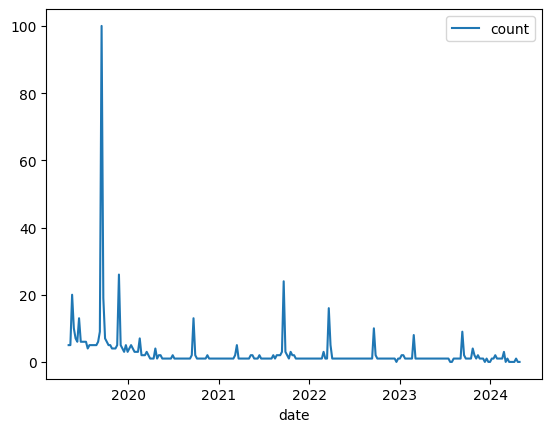

In [4]:
from media_impact_monitor.trend import get_trend
from media_impact_monitor.types_ import TrendSearch

df = get_trend(
    TrendSearch(
        trend_type="keywords",
        media_source="web_google",
        start_date="2023-07-01",
        end_date="2023-12-31",
        query='"Fridays for Future"',
    )
)
df.plot()

In [25]:
from media_impact_monitor.impact import get_impact
from media_impact_monitor.types_ import ImpactSearch, Effect

result = get_impact(
    ImpactSearch(
        cause=event_ids,
        effect=Effect(
            trend_type="keywords",
            media_source="web_google",
            query="Letzte Generation",
        ),
        method="interrupted_time_series",
    ),
)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/impact",
    "http://localhost:8000/impact",
    json={
        "cause": event_ids,
        "effect": {
            "trend_type": "keywords",
            "media_source": "web_google",
            "query": '"Letzte Generation"',
        },
        "method": "interrupted_time_series",
    },
)
res.json()
data = res.json()["data"]

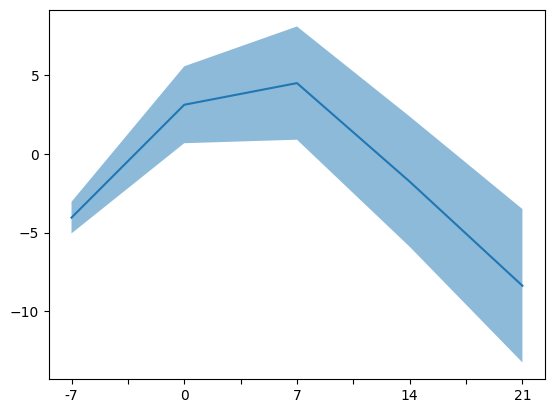

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

pd.Series(data["impact_mean"]).plot()
plt.fill_between(
    pd.Series(data["impact_mean"]).index,
    pd.Series(data["impact_mean_lower"]).values,
    pd.Series(data["impact_mean_upper"]).values,
    alpha=0.5,
)

In [ ]:
impacts__ = pd.Series(
    [list(ts.values())[4 + 14] for ts in data["individual_impacts"].values()]
)
print(impacts__.describe())
impacts__.hist(bins=50)

In [ ]:
from scipy.stats import normaltest

normaltest(impacts__)

Small p-value means that it's likely not normal. (However, large p-value does not mean anything, e. g. it can be due to small sample size.)
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html.